In [1]:
import dataclasses
import logging
import math
import os
import io
import sys
import time
import json
import random
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, DebertaV2ForSequenceClassification
import torch
from tqdm import tqdm

In [6]:
reward_name = "/home/tiger/.cache/huggingface/hub/models--OpenAssistant--reward-model-deberta-v3-large-v2/snapshots/c355404efa9ad2ad069f3a197cae0523c14244fc"
model: DebertaV2ForSequenceClassification = AutoModelForSequenceClassification.from_pretrained(reward_name)
print(model)
print(type(model))

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element

In [ ]:
model.forward()

In [2]:
with open("/opt/tiger/MoDS/quality-evaluation/input.json", "r") as f:
    data = f.read()
    data = json.loads(data)
print(len(data))

52002


In [3]:
data = json.dumps(data[:1000])
with open("/opt/tiger/MoDS/quality-evaluation/data.json", "w") as f:
    f.write(data)

In [2]:
from vllm import LLM

In [6]:
model = LLM(model="gpt2", tensor_parallel_size=6, dtype="float16")
print(model)

/home/tiger/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-05-26 17:30:16,005	INFO worker.py:1582 -- Calling ray.init() again after it has already been called.


In [1]:
from datasets import load_dataset

dataset = load_dataset("TIGER-Lab/MathInstruct", cache_dir="/mnt/bn/data-tns-live-llm/leon/datasets/")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [2]:
import polars as pl
df = pl.read_parquet("/opt/tiger/MoDS/code.parquet")

In [5]:
print(df.head())

shape: (5, 3)
┌──────────────────────────────────┬─────────────────────────────┬─────────────────────────────────┐
│ instruction                      ┆ input                       ┆ output                          │
│ ---                              ┆ ---                         ┆ ---                             │
│ str                              ┆ str                         ┆ str                             │
╞══════════════════════════════════╪═════════════════════════════╪═════════════════════════════════╡
│ Create a function that takes a…  ┆                             ┆ def f(x):                       │
│                                  ┆                             ┆     """                         │
│                                  ┆                             ┆     Takes a …                   │
│ Generate a unique 8 character …  ┆                             ┆ import string                   │
│                                  ┆                             ┆ import ran

In [6]:
data = pl.read_json("/opt/tiger/MoDS/MathInstruct.json")
print(data.head())

shape: (5, 3)
┌────────────────────────────────┬────────────────────────────────┬────────────────────────────────┐
│ source                         ┆ instruction                    ┆ output                         │
│ ---                            ┆ ---                            ┆ ---                            │
│ str                            ┆ str                            ┆ str                            │
╞════════════════════════════════╪════════════════════════════════╪════════════════════════════════╡
│ data/CoT/aqua_rat.json         ┆ The distance between two       ┆ Let's think about the          │
│                                ┆ stars…                         ┆ multi-ch…                      │
│ data/CoT/aqua_rat.json         ┆ How many ways can the letters  ┆ Let's solve the multi-choice   │
│                                ┆ …                              ┆ q…                             │
│ data/PoT/aqua_rat_filtered.jso ┆ A team of six entered for a    ┆ answers =

In [8]:
import torch
t1 = torch.load("/opt/tiger/Cherry_LLM/code_data_pre.pt")
print(type(t1))

<class 'list'>


In [9]:
print(t1[0])

{'ppl': [tensor(18.6185), 0, 0], 'sent_emb': [tensor([[-0.3425,  0.0562,  0.7246,  ..., -0.0523, -0.9365, -1.1855]],
       dtype=torch.float16), 0, 0]}


In [1]:
from datasets import load_dataset
dataset = load_dataset("parquet", data_files = "/mnt/bn/data-tns-live-llm/leon/datasets/code.parquet", split = "train")

In [4]:
print(dataset[0])

{'instruction': 'Create a function that takes a specific input and produces a specific output using any mathematical operators. Write corresponding code in Python.', 'input': '', 'output': 'def f(x):\n    """\n    Takes a specific input and produces a specific output using any mathematical operators\n    """\n    return x**2 + 3*x'}


In [6]:
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

In [7]:
def format_function(input):
    prompt_input, prompt_no_input = PROMPT_DICT["prompt_input"], PROMPT_DICT["prompt_no_input"]
    sources = prompt_input.format_map(input) if input.get("input", "") != "" else prompt_no_input.format_map(input)
    return sources

In [8]:
print(format_function(dataset[0]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a function that takes a specific input and produces a specific output using any mathematical operators. Write corresponding code in Python.

### Response:


In [5]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/pre-exp-code/")
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)


In [3]:
import torch
data = torch.load("/mnt/bn/data-tns-live-llm/leon/datasets/code_data_cherry.pt")
ifd = [d["ppl"][2]/d["ppl"][1] for d in data]
idxs = sorted(range(len(ifd)), key=lambda i: ifd[i], reverse=True)[18:1018]
# print(idxs[:1000])

In [ ]:
tmp = [ifd[idx] for idx in idxs[:1010]]
print((tmp))

In [42]:
idxs = idxs[4:]
print(idxs[:100])

[1146, 6228, 1437, 2399, 4983, 5573, 6456, 6614, 774, 4953, 5213, 5117, 3439, 1820, 664, 5604, 1940, 6951, 5688, 6945, 1562, 1658, 2625, 5097, 2049, 2225, 1422, 5623, 6860, 2833, 5649, 30, 2189, 49, 56, 7092, 1513, 5062, 752, 1991, 6371, 6330, 5187, 745, 6512, 2503, 5079, 1964, 2338, 5119, 5228, 5130, 58, 6838, 2178, 2074, 1233, 5603, 5848, 6794, 1916, 2736, 1475, 2236, 2686, 5018, 1316, 1169, 2708, 818, 1151, 1267, 6888, 2030, 5298, 5596, 2777, 6919, 853, 5223, 5729, 1957, 5407, 5480, 5544, 5452, 5629, 4891, 1853, 5303, 1780, 5382, 1066, 1587, 2347, 1615, 5309, 4880, 5888, 1560]


In [5]:
torch.save(idxs[:1000], "/mnt/bn/data-tns-live-llm/leon/datasets/code_cherry_1000.pt")

In [ ]:
import json
with open("/mnt/bn/data-tns-live-llm/leon/datasets/code-quality-evaluation.json", "r") as f:
    d1 = json.loads(f.read())
scores = [d["reward_score"] for d in d1[:10000]]
sidxs = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
print(sidxs[:1000])

In [7]:
torch.save(sidxs[:1000], "/mnt/bn/data-tns-live-llm/leon/datasets/code_MoDS_1000.pt")

In [16]:
print(scores[413])

8.421875


In [3]:
idxs = torch.load("/mnt/bn/data-tns-live-llm/leon/datasets/cherry_1000.pt")
sidxs = torch.load("/mnt/bn/data-tns-live-llm/leon/datasets/MoDS_1000.pt")

In [8]:
import polars as pl
data = pl.read_parquet("/mnt/bn/data-tns-live-llm/leon/datasets/code.parquet").to_dicts()
# with open("/mnt/bn/data-tns-live-llm/leon/datasets/", "r") as f:
#     data = json.loads(f.read())
print(len(data))

20022


In [ ]:
d1 = [data[idx] for idx in idxs[:1000]]
d2 = [data[idx] for idx in sidxs[:1000]]
print(d1[:100])
print(d2[:100])

In [10]:
with open("/mnt/bn/data-tns-live-llm/leon/datasets/cherry_code.json", "w") as f:
    f.write(json.dumps(d1, ensure_ascii=False, indent=4))

with open("/mnt/bn/data-tns-live-llm/leon/datasets/MoDS_code.json", "w") as f:
    f.write(json.dumps(d2, ensure_ascii=False, indent=4))

In [ ]:
import json
with open("/mnt/bn/data-tns-live-llm/leon/datasets/cherry_code.json", "r") as f:
    tmp = json.loads(f.read())[:100]
# with open("/mnt/bn/data-tns-live-llm/leon/datasets/tmp.json", "w") as f:
#     f.write(json.dumps(tmp))
print(tmp)

In [15]:
from transformers import AutoModelForCausalLM, LlamaForCausalLM, AutoTokenizer
from peft import PeftModel
model = AutoModelForCausalLM.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/pre-exp-code/", torch_dtype=torch.float16, output_hidden_states=True).to("cuda:0")
tokenizer = AutoTokenizer.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/pre-exp-code/")

In [12]:
d = idxs[:1000]+sidxs[:1000]
print(len(d))

2000


In [13]:
json_set = {t for t in d}
print(len(json_set))

1903


In [ ]:
print(json_set)

In [14]:
cnt = 0
for idx in idxs[:1000]:
    if idx in sidxs[:1000]: cnt+=1
print(cnt)

97


# 可视化一下MoDS和score model 选择的高质量数据的 embedding

In [17]:
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

In [18]:
from tqdm import tqdm
perplexitys = []
cherry_embeddings = []
mods_embeddings = []
both_embeddings = []
for idx in tqdm(json_set):
    data_i = data[idx]
    instruct_i = data_i['instruction']
    # input_i = ""
    temp_dict = {'instruction':instruct_i}
    promt_to_use = PROMPT_DICT["prompt_no_input"].format_map(temp_dict)
    instruct_i = promt_to_use
    input_ids = tokenizer.encode(instruct_i, return_tensors="pt", truncation=True, max_length=2048).to("cuda:0")
    with torch.no_grad(): 
        outputs = model(input_ids, labels=input_ids.contiguous())
    loss = outputs.loss
    perplexity = torch.exp(loss)
    perplexitys.append(perplexity)
    hidden_states = outputs.hidden_states
    embeddings = hidden_states[-1]
    sentence_embedding = embeddings.mean(dim=1).cpu()
    if idx in idxs[:1000] and idx in sidxs[:1000]: both_embeddings.append(sentence_embedding)
    elif idx in idxs[:1000]: cherry_embeddings.append(sentence_embedding)
    else: mods_embeddings.append(sentence_embedding)


100%|██████████| 1903/1903 [00:17<00:00, 109.78it/s]


In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 假设 cherry_embeddings, mods_embeddings, both_embeddings 是已经准备好的嵌入向量列表
# 将它们转换为 numpy 数组以便进行 t-SNE 处理
cherry_embeddings = np.array(cherry_embeddings)[:,0,:]
mods_embeddings = np.array(mods_embeddings)[:,0,:]
both_embeddings = np.array(both_embeddings)[:,0,:]
print(cherry_embeddings.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(903, 768)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


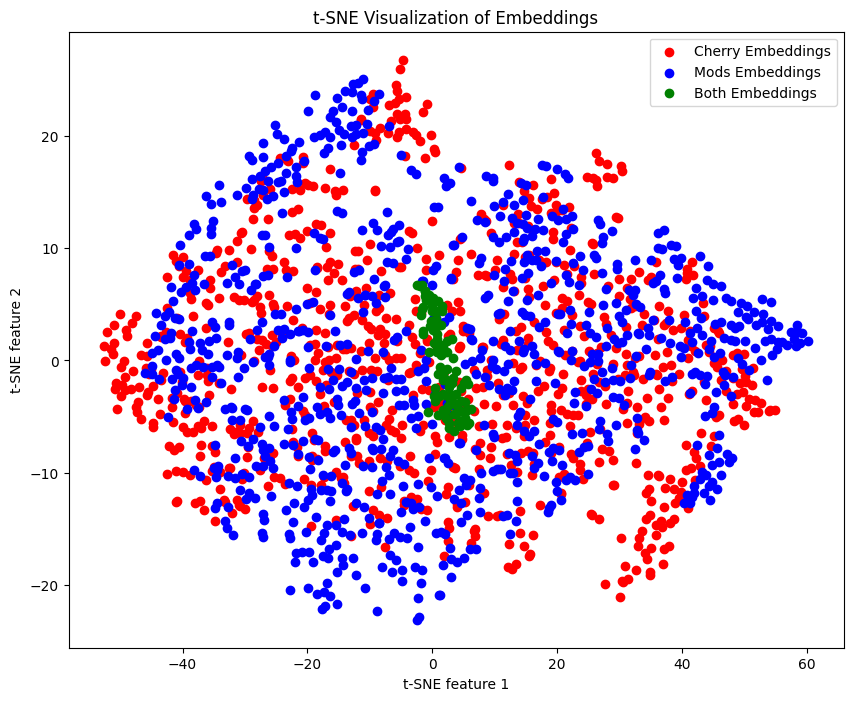

In [20]:
# 执行 t-SNE
tsne = TSNE(n_components=2, random_state=0)
cherry_tsne = tsne.fit_transform(cherry_embeddings)
mods_tsne = tsne.fit_transform(mods_embeddings)
both_tsne = tsne.fit_transform(both_embeddings)

# 绘制 t-SNE 图
plt.figure(figsize=(10, 8))

# 绘制 cherry_embeddings
plt.scatter(cherry_tsne[:, 0], cherry_tsne[:, 1], c='red', label='Cherry Embeddings')

# 绘制 mods_embeddings
plt.scatter(mods_tsne[:, 0], mods_tsne[:, 1], c='blue', label='Mods Embeddings')

# 绘制 both_embeddings
plt.scatter(both_tsne[:, 0], both_tsne[:, 1], c='green', label='Both Embeddings')

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

# 显示图形
plt.show()

# gpt4打分

In [6]:
from transformers import AutoModelForCausalLM, LlamaForCausalLM, AutoTokenizer
from peft import PeftModel
import torch
base_model = AutoModelForCausalLM.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/cherry-math/")
cherry_model = PeftModel.from_pretrained(base_model, "/mnt/bn/data-tns-live-llm/leon/datasets/cherry-math/", device_map="auto", torch_dtype=torch.float16)
cherry_tokenizer = AutoTokenizer.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/Llama-2-7b-hf", use_fast=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: Can't find 'adapter_config.json' at '/mnt/bn/data-tns-live-llm/leon/datasets/cherry-math/'

In [2]:
from transformers import AutoModelForCausalLM, LlamaForCausalLM, AutoTokenizer
from unsloth import FastLanguageModel 
model, tokenizer = FastLanguageModel.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/MoDS-math/")
print(model, tokenizer)

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla V100-SXM2-32GB. Max memory: 31.749 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.1.0+cu121. CUDA = 7.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.22.post7. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth 2024.5 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(

In [1]:
import torch
model = LlamaForCausalLM.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/MoDS-math/", cache_dir="../cache/", torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/MoDS-math/", cache_dir="../cache/")

NameError: name 'LlamaForCausalLM' is not defined

In [4]:
print(cherry_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
      

In [4]:
from datasets import load_dataset
import polars as pl
data = pl.read_parquet("/mnt/bn/data-tns-live-llm/leon/datasets/openai_humaneval/openai_humaneval/test-00000-of-00001.parquet")
rename = {"canonical_solution":"input"}
data = data.rename(rename)
print(data.columns)

['task_id', 'prompt', 'input', 'test', 'entry_point']


In [ ]:
data = data.to_dicts()

In [5]:
print(len(data))

164


In [4]:
import json
with open("/mnt/bn/data-tns-live-llm/leon/datasets/openai_humaneval/openai_humaneval/test.jsonl", "w") as f:
    for d in data:
        f.write(json.dumps(d, ensure_ascii=False) + '\n')